# Final Lab: Classification and Clustering Grab Bag

In this final lab, we will introduce two methods of classification called Neural Networks and Support Vector Machines, and an additional method of clustering called Hierarchical Agglomerative Clustering. We hope that introducing these methods will broaden your toolkit for tackling problems both for the final project and in the future. 

In [1]:
%matplotlib inline
import numpy
import math
import scipy
import random
import brewer2mpl
import matplotlib.pyplot as plt

# Neural Networks

A neural network "learns" by solving an optimization problem to choose a set of parameters that minimizes an error function, which is typically a squared error loss. This definition of learning isn't unique to a neural network model. Consider, in the simplest case, a linear model of the form $y = XB$. Given a vector of data  $y \in \mathbb{R}^m$, we choose  $B \in \mathbb{R}^n$ that minimizes $||y-XB||_2$, where $X$ is an $m$ by $n$ matrix with "training data" on the rows.  Solving this least squares minimization problem has a nice well known closed form analytical result: $\hat{B} = (X^TX)^{-1}X^Ty$. There is, however, a tradeoff between computational ease of finding optimal model parameters and model complexity.  This is evident in the linear case since the model is extremely easy to fit but has a very simple form. The neural network attempts to find a "sweet spot": while the model is highly non-linear, its particular functional form allows for a computationally slick fitting procedure called "backpropogation". 

A "neural network" is a function from $f: \mathbb{R}^m \rightarrow \{-1,1\}$. The input to each neuron is a linear combination of the outputs of each of the neurons in the lower layer. The output of the neuron is a nonlinear threshold applied to its input: it's something that maps the real line to (-1,1) in a 1-1 fashion such that "most" of the positive line is mapped pretty close to 1 and and "most" of the negative line is mapped pretty close to -1. A common choice is the function  $g(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}}$.The final output of the signal is the sign of the top neuron. Note that the top layer is constrained to have a single neuron.

The goal of fitting the model is to find a suitable set of  "weights", which we can compactly refer to as $w$, for the inputs of each of the neurons. One way to do this is to choose a set of weights that minimize the sum of squared errors for training examples we already have. The intuition here is to choose a model that is "close" to the true model, just like we would in a linear regression. However, unlike linear regression an analytical solution is not feasible because of the ugly threshold functions, so we need to resort to a computational approach like gradient descent. Gradient descent takes steps in the direction of greatest error decrease in the parameter space, hoping to find a (global) minimum. (Recall that from multivariable calculus, the gradient of a scalar field points in the direction of the greatest increase of the function, and so walking in the opposite direction points in the direction of greatest decrease repeating the argument with the negative of the function.) 

We start by initializing the model with some arbitrary set of weights. Feeding forward, given an input $x \in \mathbb{R}^m$, we may compute the output as delineated above. Hence, we may calculate the error $E = (y-f(x))^2$. Now, we compute the gradient of this error function with respect to the weights. 

The beauty of the method is that computing the gradient of the error is computationally slick and can be done recursively using the chain rule. To see this, we'll introduce some notation. Let $k = 1...L$ indicate layers, assume that $s_{jk}$ is the output of the jth neuron in layer $k$, $x_{jk}$ is the input into neuron $j$ in layer $k$, and $w_{ijk}$ is the weight for the signal input into the $j$th neuron in layer $k$ coming from the ith neuron  in layer $k-1$, so that $x_{jk} = \sum_{i=1}^{d_{k-1}}w_{ijk}s_{ik-1}$, $s_{jk} = g(x_{jk})$. Note that $d_{k-1}$ stands for the number of neurons in layer $k-1$.  By the chain rule, $$\frac{\partial E}{\partial w_{ijk}} = \frac{\partial E}{\partial s_{jk}}\frac{\partial s_{jk}}{\partial w_{ijk}}$$. Since $s_{jk}$ is linear in the weights, the tricky part is only in computing the former component of the product. We may recursively compute this as 

$$ \frac{\partial E}{\partial s_{jk}} = \frac{\partial E}{\partial x_{jk}}\frac{\partial x_{jk}}{\partial s_{jk}} = \sum_{i=1}^{d_{k+1}} \frac{\partial E}{\partial s_{ik+1}}\frac{\partial s_{ik+1}}{\partial x_{jk}}\frac{\partial x_{jk}}{\partial s_{jk}}$$

The recursion terminates since $\frac{\partial E}{\partial x_{1L}} = 2(x_{1L}-y)$. We start by computing the gradients from the top layer, and store the gradients as we progress down each layer,so that we need not recompute them. This leads to computational efficiency.  

Thus "learning" in a neural network  is nothing but switching between computing the error using the training data and updating the weights by calculating the gradient of the error function. In the code block that follows, we write a class for NeuralNetworks, and apply it to performing classification.

In [4]:
#Neural Network Class 
class Neural_Net:

	#constructor initializes a new neural network with randomly selected weights and pre-specified height, and number of neurons per layer
	def __init__(self,non,height):
		#list to store the number of neurons in each layer of the network
		self.num_of_neurons = non
		#height of the network
		self.L = height
		#list to store number of weights in each layer of the network, indexed by layer, output neuron, input neuron
		self.weights = numpy.zeros(shape=(10,10,10))
		#delta_matrix: stores the gradient that is used in backpropagation
		self.deltas = numpy.zeros(shape=(10,10))
		#matrix that stores thresholded signals
		self.signals = numpy.zeros(shape=(10,10))
		#(tunable) learning_rate used in backpropagation
		self.learning_rate = .001
		#initialize weights to be between -2 and 2
		for i in range(1,self.L+1):
			for j in range(1,self.num_of_neurons[i]+1):
				for k in range(self.num_of_neurons[i-1]+1):
					self.weights[i][j][k] = random.random()*4-2		
											
	#forward_pass computes the output of the neural network given an input
	def forward_pass(self,x):
		#(for convenience, we index neurons starting at 1 instead of zero)
		self.signals[0][0] = -1
		for i in range(1,self.num_of_neurons[0]+1):
			self.signals[0][i] = x[i-1]
		for i in range(1,self.L+1):
			self.signals[i][0] = -1
			for j in range(1,self.num_of_neurons[i]+1):
				self.signals[i][j] = self.compute_signal(i,j)
		return self.signals[self.L][1]
					
	#tune_weights performs the backpropagation algorithm given a training example as input
	def tune_weights(self,y):
		self.deltas[self.L][1] = 2*(self.signals[self.L][1]-y)*(1-math.pow(self.signals[self.L][1],2))
		for i in range(self.L-1,0,-1):
			for j in range(1,self.num_of_neurons[i]+1):
				self.deltas[i][j] = self.compute_delta(i,j)
		for i in range(1,self.L+1):
			for j in range(1,self.num_of_neurons[i]+1):
				for k in range(self.num_of_neurons[i-1]+1):
					self.weights[i][j][k] = self.weights[i][j][k]-self.learning_rate*self.signals[i-1][k]*self.deltas[i][j]
	
	#compute_signal: computes the delta for a given neuron at a given level
	def compute_signal(self,level,neuron):
		s = 0
		for i in range(self.num_of_neurons[level-1]+1):
			s += self.weights[level][neuron][i]*self.signals[level-1][i]
		return self.g(s)
	
	#compute_delta: computes the signal s for a given neuron at a given level
	def compute_delta(self,level,neuron):
		s = 0
		for j in range(1,self.num_of_neurons[level+1]+1):
			s += self.weights[level+1][j][neuron]*self.deltas[level+1][j]
		return (1-math.pow(self.signals[level][neuron],2))*s
	
	#soft threshold function
	def g(self,s):
		return (math.exp(s)-math.exp(-s))/(math.exp(s)+math.exp(-s))

Now let's train a neural network and see how well it performs on the test and training sets epoch by epoch. We will use a mock training and test set with two covariates. We instantiate a neural network with one hidden layer with four neurons, and a learning rate of .001. The learning rate is how much we scale the gradient in "walking" the parameter space. 

To gain some intuition, try to tweak some of these knobs.

Note that this will take about a minute to run!

In [6]:
#read in the train and test dat, assuming csv format
training = numpy.genfromtxt('train.csv',delimiter = ',')
testing = numpy.genfromtxt('test.csv',delimiter = ',')

#specify the number of neurons in each layer
num_of_neurons = [2,4,1]

#initialize a new neural network
network = Neural_Net(num_of_neurons,2)

#store the training error and test error during each epoch
training_error = 0
test_error = 0

#store the training and test error for all epochs
train = numpy.zeros(shape = (1000))
test = numpy.zeros(shape = (1000))

for epoch in range(1000):
    training_error = 0
    test_error = 0
    #compute the test errors
    for j in range(250):
        test_error = test_error+math.pow(network.forward_pass(testing[j]) - testing[j][2], 2)
    #compute the training errors, SEQUENTIALLY. In other words, we perform backpropagation for *every* example
    #instead of all at once. 
    for i in range(25):
        training_error = training_error+math.pow(network.forward_pass(training[i])- training[i][2], 2)
        network.tune_weights(training[i][2])	   
    training_error = training_error/25
    test_error = test_error/250
    train[epoch] = training_error
    test[epoch]  = test_error

IndexError: invalid index to scalar variable.

Now let's compare the training and test error, epoch by epoch. Do we see signs of overfitting?

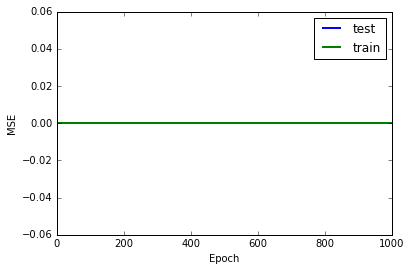

In [7]:
fig, ax = plt.subplots()
ax.plot(numpy.arange(1000), test, lw=2, label = 'test')
ax.plot(numpy.arange(1000), train, lw=2, label = 'train')
ax.legend(loc=0)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')